Overview for Candidate

You are the first data scientist in an AI Labs team that wants to unlock value from 15+ years of incentive compensation data. We will give you a simplified, anonymized dataset that mimics real-world structures (multiple years, employees, roles, quotas, attainment, and payouts). Your goal is to:

Understand the data and assess quality.

Derive meaningful insights related to incentive plans and performance.

Propose reusable features and metrics that can power AI-driven features in the product.

Demonstrate how you would communicate your findings to product stakeholders.

Assume we provide a CSV (or small set of CSVs) with columns such as:

• employee_id

• role

• region

• plan_type (e.g., standard, SPIF-heavy, new-logo focused)

• fiscal_year

• quota_amount

• actual_attainment

• payout_amount

• tenure_in_role_months

• team_id

• product_mix (e.g., percent of revenue from different product families)


Part 1: Data Understanding and Quality

Deliverables:

• A short written summary (1–2 pages or a well-commented notebook section) that covers:

– Key data quality issues you observed (missing values, outliers, inconsistent entries, etc.).

– How you handled or would handle these issues.

– Any assumptions you made about the data.

What we are looking for:

• Ability to reason about real-world messy business data.

• Practical judgment rather than perfectionism.

• Clear articulation of assumptions and limitations.


Part 2: Insights and Patterns

Deliverables:

• Analysis that addresses questions such as:

– How does attainment distribution look across different roles, regions, and plan types?

– Are there patterns in over- or under-attainment across years or cohorts?

– Do certain plan types appear to be systematically more generous or more punitive?

– Are there relationships between tenure, attainment, and payout?

• At least 3–5 clear, business-relevant insights you would highlight to an SVP of Sales or Compensation.


What we are looking for:

• Ability to connect the analysis to real business questions around incentives, fairness, performance, and risk.

• Clear, concise summaries that a non-technical stakeholder can understand.


Part 3: Features and Scoring Concepts

Deliverables:

• A proposed set of 5–10 reusable features or metrics that could be used across AI agents or analytics (for example, “plan volatility score,” “quota stress index,” “historical attainment consistency,” “overpayment risk score”).

• A brief explanation for each feature:

– What it measures.

– How it is calculated (at a high level).

– Which persona would use it (e.g., comp admin, sales leader, finance).

• Optionally, you may propose a simple scoring approach (e.g., a risk score from 0–100 for a plan or a quota reasonableness label). You do not need to build a complex model; a heuristic or simple model is fine.

What we are looking for:

• Product thinking and an understanding of how signals become features.

• Interpretability and usefulness for real users.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Settings for clean plots
plt.rcParams["figure.dpi"] = 140

DATA_PATH = "incentive_data.csv"
df = pd.read_csv(DATA_PATH)

df.head()


,employee_id,role,region,plan_type,fiscal_year,quota_amount,actual_attainment,payout_amount,tenure_in_role_months,team_id,product_mix_core,product_mix_adjacent
0,E01391,Customer Success,NaN,new-logo,2015,604395.12,621611.51,57575.39,23.0,T018,0.6866,0.3134
1,E02086,Account Executive,APAC,standard,2014,946222.31,1317618.75,150285.03,27.0,T027,0.6689,0.3311
2,E05166,BDR,EMEA,standard,2010,339620.39,421240.52,55252.76,0.0,T118,0.6393,0.3607
3,E00617,BDR,EMEA,standard,2011,317186.71,363064.37,41303.73,0.0,T233,0.6985,0.3015
4,E00652,Channel Manager,LATAM,new-logo,2012,544367.28,562570.28,60741.80,40.0,T045,0.6258,0.3742


## 1) Data Understanding

### Columns (assumed meaning)
- **employee_id**: unique employee identifier  
- **role**: job role (AE, Sales Manager, BDR, etc.)  
- **region**: NA / EMEA / APAC / LATAM  
- **plan_type**: standard / SPIF-heavy / new-logo  
- **fiscal_year**: year (2010–2024)  
- **quota_amount**: annual quota target  
- **actual_attainment**: achieved value vs quota metric  
- **payout_amount**: incentive payout amount for the year  
- **tenure_in_role_months**: tenure (months)  
- **team_id**: team identifier  
- **product_mix_core / product_mix_adjacent**: simplified mix shares (sum to ~1)

### Grain check
Target grain is **employee × year** (one record per employee per fiscal year).  


In [5]:
# Basic profiling
print("Rows, Cols:", df.shape)
print("Years:", df["fiscal_year"].min(), "to", df["fiscal_year"].max())
print("Unique employees:", df["employee_id"].nunique())
print("Unique teams:", df["team_id"].nunique())

for c in ["role", "region", "plan_type"]:
    print("\n", c, df[c].value_counts(dropna=False).head(10))


Rows, Cols: (50000, 12)
Years: 2010 to 2024
Unique employees: 5997
Unique teams: 249

 role role
Account Executive    23283
BDR                   9850
Sales Manager         9073
Customer Success      3966
Channel Manager       3828
Name: count, dtype: int64

 region region
NaN      18928
EMEA     14060
APAC     11125
LATAM     5887
Name: count, dtype: int64

 plan_type plan_type
standard      32152
SPIF-heavy     9770
new-logo       8027
NaN              51
Name: count, dtype: int64


## 2) Part 1 — Data Quality Checks

We look for:
- missing values
- invalid values (zero/negative quota, negative attainment/payout where not expected)
- outliers (extreme payout or attainment ratios)
- category consistency (role/region/plan_type cleanliness)


In [6]:
# Missingness
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0].to_frame("missing_rate").head(12)


,missing_rate
region,0.37856
tenure_in_role_months,0.01974
quota_amount,0.00488
payout_amount,0.00454
plan_type,0.00102


In [7]:
# Invalid / suspicious values
checks = {
    "quota_amount_missing": df["quota_amount"].isna().mean(),
    "quota_amount_nonpositive": (df["quota_amount"].fillna(0) <= 0).mean(),
    "actual_attainment_negative": (df["actual_attainment"] < 0).mean(),
    "payout_amount_negative": (df["payout_amount"] < 0).mean(),
}

pd.Series(checks).to_frame("rate")


,rate
quota_amount_missing,0.00488
quota_amount_nonpositive,0.00658
actual_attainment_negative,0.00172
payout_amount_negative,0.00150


### Derived metrics (core to the business questions)

- **attainment_ratio** = actual_attainment / quota_amount  
- **payout_to_quota** = payout_amount / quota_amount  
- **payout_rate** = payout_amount / actual_attainment (only meaningful when attainment > 0)

We also bucket tenure for cohort views.


In [8]:
df["attainment_ratio"] = df["actual_attainment"] / df["quota_amount"]
df["payout_to_quota"] = df["payout_amount"] / df["quota_amount"]
df["payout_rate"] = df["payout_amount"] / df["actual_attainment"]

bins = [-0.1, 6, 12, 24, 60, 120, 1000]
labels = ["0–6m", "6–12m", "1–2y", "2–5y", "5–10y", "10y+"]
df["tenure_bucket"] = pd.cut(df["tenure_in_role_months"], bins=bins, labels=labels)

df[["attainment_ratio","payout_to_quota","payout_rate","tenure_bucket"]].describe(percentiles=[0.01,0.05,0.5,0.95,0.99])


,attainment_ratio,payout_to_quota,payout_rate
count,49699.000000,49472.000000,49715.000000
mean,1.029863,0.103643,0.088326
std,0.407632,0.077423,0.040454
min,-3.500000,-0.083603,-0.190902
1%,0.384545,0.000000,0.000000
5%,0.524225,0.003383,0.005684
50%,0.967443,0.092399,0.093407
95%,1.751434,0.237964,0.152869
99%,2.363524,0.385032,0.189495
max,5.000000,0.600000,0.289842


In [9]:
# Outliers: view raw tails for ratios (no filtering yet)
for c in ["attainment_ratio", "payout_to_quota"]:
    s = df[c].replace([np.inf, -np.inf], np.nan).dropna()
    print("\n", c)
    print("p1,p5,p50,p95,p99:", np.quantile(s, [0.01,0.05,0.5,0.95,0.99]))



 attainment_ratio
p1,p5,p50,p95,p99: [0.38454533 0.52422487 0.96744326 1.75143354 2.36352425]

 payout_to_quota
p1,p5,p50,p95,p99: [0.         0.00338343 0.09239935 0.23796364 0.38503173]


### How we handle issues 

For the analyses below, we create a **valid analytic subset**:
- quota_amount > 0
- non-negative actual_attainment (negative may represent chargebacks; keep for audit flags but exclude from core distributions)
- required dimensions present (role/region/plan_type/year)

For plots, we **cap** ratios for visualization (does not delete raw values):
- attainment_ratio capped at 3.0
- payout_to_quota capped at 0.8


In [10]:
valid = df.dropna(subset=["quota_amount","actual_attainment","payout_amount","role","region","plan_type","fiscal_year"])
valid = valid[(valid["quota_amount"] > 0) & (valid["actual_attainment"] >= 0)]
valid = valid.replace([np.inf, -np.inf], np.nan).dropna(subset=["attainment_ratio","payout_to_quota"])

valid["attainment_ratio_c"] = valid["attainment_ratio"].clip(0, 3.0)
valid["payout_to_quota_c"] = valid["payout_to_quota"].clip(-0.1, 0.8)

print("Valid rows:", len(valid), "out of", len(df))


Valid rows: 30655 out of 50000


## 3) Part 2 — Insights & Patterns

We answer:
- How attainment differs across **roles, regions, plan types**
- Whether there are **yearly/cohort** patterns
- Which plan types are more **generous or punitive**
- Relationship between **tenure, attainment, payout**


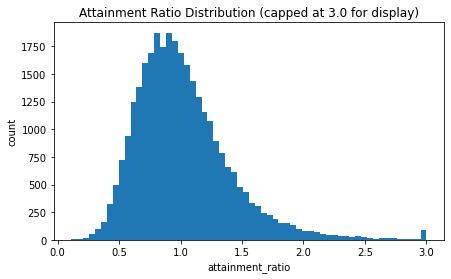

In [11]:
# Chart 1: Attainment distribution (overall)
plt.figure(figsize=(7,4))
plt.hist(valid["attainment_ratio_c"], bins=60)
plt.title("Attainment Ratio Distribution (capped at 3.0 for display)")
plt.xlabel("attainment_ratio")
plt.ylabel("count")
plt.show()


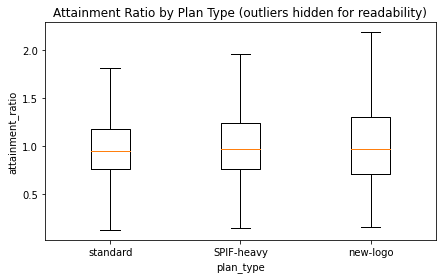

In [12]:
# Chart 2: Attainment by plan type (boxplot)
plan_order = ["standard","SPIF-heavy","new-logo"]
data = [valid.loc[valid["plan_type"]==p, "attainment_ratio_c"] for p in plan_order]

plt.figure(figsize=(7,4))
plt.boxplot(data, labels=plan_order, showfliers=False)
plt.title("Attainment Ratio by Plan Type (outliers hidden for readability)")
plt.xlabel("plan_type")
plt.ylabel("attainment_ratio")
plt.show()


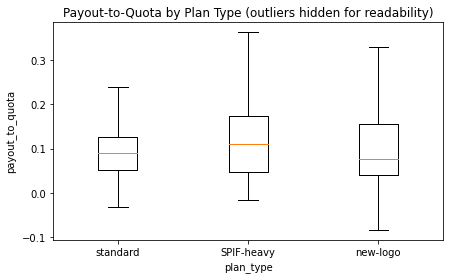

In [13]:
# Chart 3: Payout-to-quota by plan type (boxplot)
data = [valid.loc[valid["plan_type"]==p, "payout_to_quota_c"] for p in plan_order]

plt.figure(figsize=(7,4))
plt.boxplot(data, labels=plan_order, showfliers=False)
plt.title("Payout-to-Quota by Plan Type (outliers hidden for readability)")
plt.xlabel("plan_type")
plt.ylabel("payout_to_quota")
plt.show()


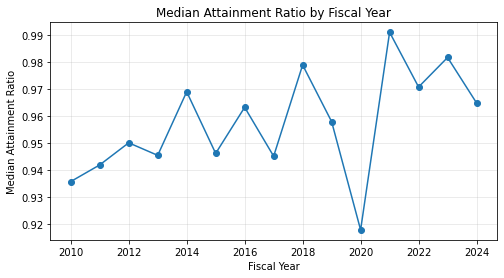

,median_attainment
fiscal_year,
2010,0.935792
2011,0.941956
2012,0.950136
2013,0.945494
2014,0.969022


In [14]:
# Chart 4: Year trend (median attainment)
year_median = (
    valid
    .groupby("fiscal_year")["attainment_ratio"]
    .median()
)

plt.figure(figsize=(8,4))
plt.plot(
    year_median.index.to_numpy(),
    year_median.to_numpy(),
    marker="o"
)
plt.title("Median Attainment Ratio by Fiscal Year")
plt.xlabel("Fiscal Year")
plt.ylabel("Median Attainment Ratio")
plt.grid(True, alpha=0.3)
plt.show()

year_median.to_frame("median_attainment").head()



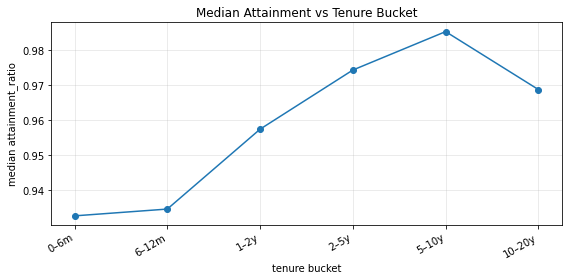

,count,median,mean
tenure_bucket2,,,
0–6m,12520,0.932685,1.017207
6–12m,832,0.934625,1.000098
1–2y,1667,0.957397,1.017910
2–5y,4957,0.974260,1.030149
5–10y,6274,0.985211,1.030445
10–20y,3835,0.968691,1.016869


In [15]:
# Chart 5: Tenure vs attainment (binned)
ten_bins = [0,6,12,24,60,120,240]
ten_labels = ["0–6m","6–12m","1–2y","2–5y","5–10y","10–20y"]
valid["tenure_bucket2"] = pd.cut(valid["tenure_in_role_months"], bins=ten_bins, labels=ten_labels, include_lowest=True)

ten_summary = valid.groupby("tenure_bucket2")["attainment_ratio"].agg(["count","median","mean"])

plt.figure(figsize=(8,4))
plt.plot(range(len(ten_summary)), ten_summary["median"].values, marker="o")
plt.title("Median Attainment vs Tenure Bucket")
plt.xlabel("tenure bucket")
plt.ylabel("median attainment_ratio")
plt.xticks(range(len(ten_summary)), ten_summary.index, rotation=30, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ten_summary


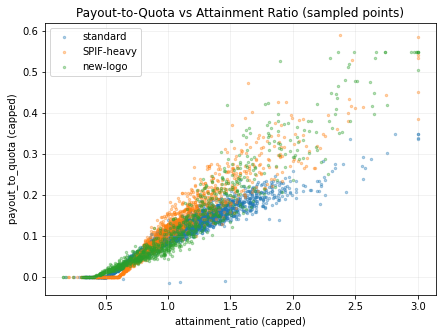

In [16]:
# Chart 6: Pay curve proxy (payout_to_quota vs attainment_ratio) by plan
sample = valid.sample(n=min(6000, len(valid)), random_state=42)

plt.figure(figsize=(7,5))
for p in plan_order:
    sub = sample[sample["plan_type"]==p]
    plt.scatter(sub["attainment_ratio_c"], sub["payout_to_quota_c"], s=6, alpha=0.35, label=p)

plt.title("Payout-to-Quota vs Attainment Ratio (sampled points)")
plt.xlabel("attainment_ratio (capped)")
plt.ylabel("payout_to_quota (capped)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


In [17]:
# SVP-style insights (computed, then summarized in plain language)

# Attainment buckets
att_buckets = pd.cut(valid["attainment_ratio"], bins=[-np.inf,0.8,1.0,1.2,np.inf], labels=["<0.8","0.8–1.0","1.0–1.2",">1.2"])
bucket_share = att_buckets.value_counts(normalize=True).sort_index()

# Quota stress pockets (highest under-0.8 share)
quota_stress = (valid["attainment_ratio"] < 0.8).groupby([valid["region"], valid["role"]]).mean().reset_index(name="pct_under_0p8")
quota_stress_top = quota_stress.sort_values("pct_under_0p8", ascending=False).head(10)

# Plan generosity near-quota
near = valid[(valid["attainment_ratio"] >= 0.9) & (valid["attainment_ratio"] <= 1.1)]
gen = near.groupby("plan_type")["payout_to_quota"].median().sort_values(ascending=False)

# Overpayment risk threshold (99th percentile in near-quota band)
risk_thresh = float(near["payout_to_quota"].quantile(0.99))
overpay_rate = float((near["payout_to_quota"] > risk_thresh).mean())

bucket_share.to_frame("share"), quota_stress_top, gen.to_frame("median_payout_to_quota_0.9-1.1"), risk_thresh, overpay_rate


(                     share
 attainment_ratio          
 <0.8              0.303605
 0.8–1.0           0.245604
 1.0–1.2           0.192334
 >1.2              0.258457,
    region               role  pct_under_0p8
 2    APAC    Channel Manager       0.347942
 13  LATAM   Customer Success       0.336562
 10  LATAM  Account Executive       0.334850
 3    APAC   Customer Success       0.323409
 12  LATAM    Channel Manager       0.322940
 4    APAC      Sales Manager       0.319398
 14  LATAM      Sales Manager       0.314231
 11  LATAM                BDR       0.312801
 0    APAC  Account Executive       0.308826
 1    APAC                BDR       0.306695,
             median_payout_to_quota_0.9-1.1
 plan_type                                 
 SPIF-heavy                        0.116810
 standard                          0.096989
 new-logo                          0.080724,
 0.16200961777806083,
 0.010012873694750393)

## 4) Key Takeaways (executive-friendly)

Use the outputs above to craft 3–5 insights:
- **Quota stress**: where many reps systematically under-attain
- **Plan generosity / punitive behavior**: payout-to-quota differences at similar attainment
- **Year shocks**: macro factors or quota resets drive shifts
- **Tenure ramp**: new reps have higher volatility → ramp guardrails
- **Overpayment risk**: extreme payouts for moderate attainment → audit/controls


## 5) Part 3 — Proposed Reusable Features & Scores (product-ready)

Below is a feature catalog you can ship into an AI/analytics layer. Each metric is interpretable, reusable, and ties to a persona.

**Examples:**
- Quota Stress Index (QSI)
- Attainment Consistency Score
- Plan Generosity Index
- Punitive Drop-off Score
- Accelerator Sensitivity Score
- Overpayment Risk Score
- Quota Reasonableness Label
- Team Concentration Risk
- Product Mix Complexity Score


In [18]:
# Example: compute 3 metrics at group level (extend as needed)

# 1) Quota Stress Index (by region, role)
qsi = (valid["attainment_ratio"] < 0.8).groupby([valid["region"], valid["role"]]).mean().rename("quota_stress_index").reset_index()

# 2) Plan Generosity Index (near-quota median payout_to_quota)
near = valid[(valid["attainment_ratio"] >= 0.9) & (valid["attainment_ratio"] <= 1.1)]
plan_gen = near.groupby("plan_type")["payout_to_quota"].median().rename("median_payout_to_quota_near_quota").reset_index()

# 3) Team concentration risk: payout share from top 10% earners within team-year
tmp = valid.copy()
tmp["team_year"] = tmp["team_id"].astype(str) + "-" + tmp["fiscal_year"].astype(int).astype(str)

def top10_share(x):
    x = x.sort_values(ascending=False)
    k = max(1, int(np.ceil(0.10 * len(x))))
    return x.iloc[:k].sum() / x.sum() if x.sum() != 0 else np.nan

team_conc = tmp.groupby("team_year")["payout_amount"].apply(top10_share).dropna().rename("top10_payout_share")
team_conc.describe(percentiles=[0.5,0.9,0.95])


count    3729.000000
mean        0.471498
std         0.165628
min         0.149579
50%         0.447254
90%         0.696373
95%         0.778024
max         1.000000
Name: top10_payout_share, dtype: float64